# 1. Attention is All You Need (NIPS 2017) 실습

- 본 코드는 기본적으로 Transformer 논문의 내용을 최대한 따릅니다.
- 본 논문은 딥러닝 기반의 자연어 처리 기법의 기본적인 구성을 이해하고 공부하는 데 도움을 줍니다.
- 2020년 기준 가장 뛰어난 번역 모델들은 본 논문에서 제안한 Transformer 기반의 아키텍처를 따르고 있습니다.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src='https://miro.medium.com/max/1838/1*BHzGVskWGS_3jEcYYi6miQ.png' width=500/>

<br>

## 1.1 BLEU Score 계산을 위한 라이브러리 업데이트

In [ ]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 1.2 MB 13.2 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.10.0
    Uninstalling torchtext-0.10.0:
      Successfully uninstalled torchtext-0.10.0


<br>

## 1.2 데이터 전처리 (Preprocessing)

### 1.2.1 spaCy 라이브러리

- 문장의 토큰화(tokenization), 태깅(tagging) 등의 전처리 기능을 위한 라이브러리

In [ ]:
# 영어(English)와 독일어(Deutsch) 전처리 모듈 설치
%%capture
!python -m spacy download en
!python -m spacy download de

In [ ]:
import spacy

spacy_en = spacy.load('en') # 영어 토큰화
spacy_de = spacy.load('de') # 독일어 토큰화

<br>

- 간단히 토큰화 기능 사용해보기

In [ ]:
tokenized = spacy_en.tokenizer('I am graduate student.')

for i, token in enumerate(tokenized):
    print(f"{i}: {token.text}")

0: I
1: am
2: graduate
3: student
4: .


<br>

### 1.2.2 토큰화 함수 정의

- 영어(English) 및 독일어(Deutsch) 토큰화 함수 정의

In [ ]:
# tokenize_de(): 독일어 문장을 토큰화 하는 함수 (순서를 뒤집지 않음)
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

# tokenize_en(): 영어 문장을 토큰화 하는 함수
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

<br>

### 1.2.3 `Field` 정의

- 필드(field) 라이브러리를 이용해 데이터셋에 대한 구체적인 전처리 내용을 명시한다.
- Seq2seq 모델과는 다르게 `batch_first` 속성의 값을 `True`로 설정한다.
- 번역 목표
  - 소스(SRC): 독일어
  - 목표(TRG): 영어

In [ ]:
from torchtext.data import Field

SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)

<br>

### 1.2.4 `Multi30k` 데이터 불러오기

- 대표적인 영어-독어 번역 데이터셋인 `Multi30k`를 불러온다.

In [ ]:
from torchtext.datasets import Multi30k

train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 1.21MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 229kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 221kB/s]


In [ ]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset.examples)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개
테스트 데이터셋(testing dataset) 크기: 1000개


<br>

- 학습 데이터 중 하나를 선택해 출력

In [ ]:
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

['ein', 'mann', ',', 'der', 'mit', 'einer', 'tasse', 'kaffee', 'an', 'einem', 'urinal', 'steht', '.']
['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']


<br>

### 1.2.5 단어 사전 생성

- 필드(field) 객체의 `build_vocab` 메서드를 이용해 영어와 독어의 단어 사전을 생성한다.
- 최소 2번 이상 등장한 단어만을 선택한다.

In [ ]:
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 7855
len(TRG): 5893


In [ ]:
print(TRG.vocab.stoi["abcabc"]) # 없는 단어: 0
print(TRG.vocab.stoi[TRG.pad_token]) # 패딩(padding): 1
print(TRG.vocab.stoi["<sos>"]) # <sos>: 2
print(TRG.vocab.stoi["<eos>"]) # <eos>: 3
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

0
1
2
3
4112
1752


<br>

### 1.2.6 시퀀스 길이별 배치 생성 (`BucketIterator`)

- 한 문장에 포함된 단어가 순서대로 나열된 상태로 네트워크에 입력되어야 한다.
- 따라서 하나의 배치에 포함된 문장들이 가지는 단어의 개수가 유사하도록 만들면 좋다.
- 이를 위해 `BucketIterator`를 사용한다.
- 배치 크기(batch size): 128

In [ ]:
from torchtext.data import BucketIterator
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

BATCH_SIZE = 128

# 일반적인 data loader의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device
)

device: cuda


In [ ]:
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"{i:02d} 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for j in range(src.shape[1]):
        print(f"idx {j}: {src[0][j].item()}") # src: [seq_num, seq_len]

    print('-'*30)
    # 첫 번째 배치만 확인
    if i == 5:
        break

00 번째 배치 크기: torch.Size([128, 26])
idx 0: 2
idx 1: 18
idx 2: 30
idx 3: 53
idx 4: 11
idx 5: 1121
idx 6: 1708
idx 7: 4898
idx 8: 416
idx 9: 4
idx 10: 3
idx 11: 1
idx 12: 1
idx 13: 1
idx 14: 1
idx 15: 1
idx 16: 1
idx 17: 1
idx 18: 1
idx 19: 1
idx 20: 1
idx 21: 1
idx 22: 1
idx 23: 1
idx 24: 1
idx 25: 1
------------------------------
01 번째 배치 크기: torch.Size([128, 28])
idx 0: 2
idx 1: 5
idx 2: 2563
idx 3: 4995
idx 4: 83
idx 5: 58
idx 6: 118
idx 7: 10
idx 8: 61
idx 9: 5
idx 10: 2583
idx 11: 4
idx 12: 3
idx 13: 1
idx 14: 1
idx 15: 1
idx 16: 1
idx 17: 1
idx 18: 1
idx 19: 1
idx 20: 1
idx 21: 1
idx 22: 1
idx 23: 1
idx 24: 1
idx 25: 1
idx 26: 1
idx 27: 1
------------------------------
02 번째 배치 크기: torch.Size([128, 25])
idx 0: 2
idx 1: 5
idx 2: 13
idx 3: 7
idx 4: 114
idx 5: 97
idx 6: 62
idx 7: 11
idx 8: 6
idx 9: 3234
idx 10: 17
idx 11: 34
idx 12: 154
idx 13: 4
idx 14: 3
idx 15: 1
idx 16: 1
idx 17: 1
idx 18: 1
idx 19: 1
idx 20: 1
idx 21: 1
idx 22: 1
idx 23: 1
idx 24: 1
------------------------------

<br>

## 1.3 Multi-Head Attention 아키텍처

### 1.3.1 구현 내용 설명

- 어텐션(attention)은 3가지 요소를 입력으로 받는다.
  - 쿼리 (queries)
  - 키 (keys)
  - 값 (values)
- 현재 구현에서는 Query, Key, Value의 차원이 모두 같다.

<br>

### 1.3.2 하이퍼파라미터 (hyperparameter)

- `hidden_dim`
  - 하나의 단어에 대한 임베딩 차원
- `n_heads`
  - 헤드(head)의 개수
  - scaled dot-product attention의 개수
- `dropout_ratio`
  - 드롭아웃(dropout) 비율

<br>

### 1.3.3 구현

In [ ]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # head 개수 (서로 다른 attention 컨셉의 수)
        self.head_dim = hidden_dim // n_heads # 각 head의 임베딩 차원

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        # query:    [batch_size, query_len, hidden_dim]
        # key:      [batch_size, key_len,   hidden_dim]
        # value:    [batch_size, value_len, hidden_dim]

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len,   hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim -> n_heads x head_dim 형태로 변경
        # n_heads개의 서로 다른 attention 컨셉을 학습하도록 유도
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len,   head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산
        #energy = torch.matmul(Q, K.transpose(-1, -2)) / self.scale
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        # energy: [batch_size, n_heads, query_len, key_len]

        # mask를 사용하는 경우
        if mask is not None:
            # mask 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)
        
        # attention score 계산 (각 단어에 대한 확률값)
        attention = torch.softmax(energy, dim=-1)
        # attention: [batch_size, n_heads, query_len, key_len]

        # scaled dot-product attention 계산
        x = torch.matmul(self.dropout(attention), V)
        # x: [batch_size, num_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()
        # x: [batch_size, query_len, num_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim)
        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)
        # x: [batch_size, query_len, hidden_dim]

        return x, attention

<br>

## 1.4 Position-wise Feedforward 아키텍처

#### 1.4.1 구현 내용 설명

- 입력과 출력의 차원이 동일하다.

<br>

### 1.4.2 하이퍼파라미터 (hyperparameter)

- `hidden_dim`
  - 하나의 단어에 대한 임베딩 차원
- `pf_dim`
  - Feedforward layer에서의 내부 임베딩 차원
- `dropout_ratio`
  - 드롭아웃 비율

<br>

### 1.4.3 구현

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):
        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))
        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)
        # xX: [batch_size, seq_len, hidden_dim]

        return x

<br>

## 1.5 Encoder Layer 아키텍처

### 1.5.1 구현 내용 설명

- 하나의 인코더 레이어에 대해 정의한다.

<br>

- 입력과 출력의 차원이 같다.
- 이러한 특징을 이용해 트랜스포머의 인코더는 인코더 레이어를 여러 번 중첩해 사용한다.

<br>

- `<pad>` 토큰에 대하여 mask 값을 0으로 설정한다.

<br>

### 1.5.2 하이퍼파라미터 (hyperparameter)

- `hidden_dim`
  - 하나의 단어에 대한 임베딩 차원
- `n_heads`
  - head의 개수
  - scaled dot-product attention의 개수
- `pf_dim`
  - Feedforward layer에서의 내부 임베딩 차원
- `dropout_ratio`
  - 드롭아웃 비율

<br>

### 1.5.3 구현

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src, src_mask): # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
        # src: [batch_size, seq_len, hidden_dim]
        # src_mask: [batch_size, seq_len]

        # self attention
        # 필요한 경우 mask 행렬을 이용하여 attention할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        # src: [batch_size, seq_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual connection and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        # src: [batch_size, seq_len, hidden_dim]

        return src

<br>

## 1.6 Encoder 아키텍처

### 1.6.1 구현 내용 설명

- 전체 인코더 아키텍처를 정의한다.
- 원본 논문과는 다르게 positional embedding을 학습하는 형태로 구현한다.
  - BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식
- `<pad>` 토큰에 대하여 mask값을 0으로 설정한다.

<br>

### 1.6.2 하이퍼파라미터 (hyperparameter)

- `input_dim`
  -  하나의 단어에 대한 원-핫 인코딩 차원
- `hidden_dim`
  - 하나의 단어에 대한 임베딩 차원
- `n_layers`
  - 내부적으로 사용할 인코더 레이어의 개수
- `n_heads`
  - head의 개수
  - scaled dot-product attention의 개수
- `pf_dim`
  - Feedforward layer에서의 내부 임베딩 차원
- `dropout_ratio`
  - 드롭아웃 비율
- `max_length`
  - 문장 내 최대 단어 개수

<br>

### 1.6.3 구현

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList(
            [EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)]
        )

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):
        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos: [batch_size, src_len]

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        src = self.dropout(
            (self.tok_embedding(src) * self.scale) + self.pos_embedding(pos)
        )
        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            src = layer(src, src_mask)
        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력 반환

<br>

## 1.7 Decoder Layer 아키텍처

### 1.7.1 구현 내용 설명

- 하나의 디코더 레이어에 대해 정의한다.

<br>

- 입력과 출력의 차원이 같다.
- 이러한 특징을 이용해 트랜스포머의 디코더는 디코더 레이어를 여러 번 중첩해 사용한다.

<br>

- 디코더 레이어에서는 두 개의 Multi-Head Attention layer가 사용된다.

<br>

- 소스 문장의 `<pad>` 토큰에 대하여 mask 값을 0으로 설정한다.
- 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용한다.

<br>

### 1.7.2 하이퍼파라미터 (hyperparameter)

- `hidden_dim`
  - 하나의 단어에 대한 임베딩 차원
- `n_heads`
  - head의 개수
  - scaled dot-product attention의 개수
- `pf_dim`
  - Feedforward layer에서의 내부 임베딩 차원
- `dropout_ratio`
  - 드롭아웃 비율

<br>

### 1.7.3 구현

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)

        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, trg, enc_src, trg_mask, src_mask): # 인코더의 출력값(enc_src)을 attention 하는 구조
        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention: 자기 자신에 대하여 attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention: 디코더의 query를 이용해 인코더를 attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual connection and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        # trg: [batch_size, trg_len, hidden_dim]

        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

<br>

## 1.8 Decoder 아키텍처

### 1.8.1 구현 내용 설명

- 전체 디코더 아키텍처를 정의한다.

<br>

- 원본 논문과는 다르게 positional embedding을 학습하는 형태로 구현한다.
  - BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식

<br>

- Seq2seq과는 마찬가지로 실제로 추론(inference) 시기에서는 디코더를 반복적으로 넣을 필요가 있다.
- 학습(training) 시기에서는 한 번에 출력 문장을 구해 학습할 수 있다.

<br>

- `<pad>` 토큰에 대하여 mask값을 0으로 설정한다.
- 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용한다.

<br>

### 1.8.2 하이퍼파라미터 (hyperparameter)

- `output_dim`
  -  하나의 단어에 대한 원-핫 인코딩 차원
- `hidden_dim`
  - 하나의 단어에 대한 임베딩 차원
- `n_layers`
  - 내부적으로 사용할 인코더 레이어의 개수
- `n_heads`
  - head의 개수
  - scaled dot-product attention의 개수
- `pf_dim`
  - Feedforward layer에서의 내부 임베딩 차원
- `dropout_ratio`
  - 드롭아웃 비율
- `max_length`
  - 문장 내 최대 단어 개수

<br>

### 1.8.3 구현

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList(
            [DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)]
        )

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)
        # output: [batch_size, trg_len, output_dim]

        return output, attention

<br>

## 1.9 Transformer 아키텍처

### 1.9.1 구현 내용 설명

- 최종적인 전체 트랜스포머(Transformer) 모델을 정의한다.
- 입력이 들어왔을 때 앞서 정의한 인코더와 디코더를 거쳐 출력 문장을 생성한다.

<br>

### 1.9.2 구현

In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # make_src_mask(): 소스 문장의 <pad> 토큰에 대하여 mask값을 0으로 설정
    def make_src_mask(self, src):
        # src: [batch_size, src_len]

        """ (마스크 예시): <pad> 토큰 가리기
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # make_trg_mask(): 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):
        # trg: [batch_size, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시): <pad> 토큰 가리기
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        """ (마스크 예시): 다음 단어 무조건 가리기
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):
        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        # src_mask: [batch_size, 1, 1, src_len]
        trg_mask = self.make_trg_mask(trg)
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)
        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

<br>

## 1.10 학습 (Training)

### 1.10.1 하이퍼파라미터 설정

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

<br>

### 1.10.2 모델 초기화

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

print(f"SRC pad token {SRC.pad_token}'s idx: {SRC_PAD_IDX}")
print(f"TRG pad token {TRG.pad_token}'s idx: {TRG_PAD_IDX}")

SRC pad token <pad>'s idx: 1
TRG pad token <pad>'s idx: 1


In [ ]:
# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

In [ ]:
# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

<br>

### 1.10.3 모델 가중치 파라미터 초기화

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,853 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
 

<br>

### 1.10.4 loss 및 optimizer 정의

- Adam optimizer로 학습 최적화
- loss 계산 시 뒷 부분의 패딩(padding)에 대해서는 값 무시

In [ ]:
import torch.optim as optim

LEARNING_RATE = 0.0005

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

<br>

### 1.10.5 모델 학습(train) 함수 정의

In [ ]:
from tqdm import tqdm

def train(model, iterator, optimizer, criterion, clip, device):
    model.train() # 학습 모드
    epoch_loss = 0

    for i, batch in enumerate(tqdm(iterator)): # 전체 학습 데이터 확인
        src = batch.src.to(device)
        # src: [batch_size, src_len]
        trg = batch.trg.to(device)
        # trg: [batch_size, trg_len]

        optimizer.zero_grad()

        # src: 입력을 할 때는 시작 인덱스(<sos>)부터 시작하도록 처리
        # trg[:,:-1]: 출력 단어의 마지막 인덱스(<eos>)는 제외
        output, _ = model(src, trg[:,:-1])
        # output: [batch_size, (trg_len-1), output_dim]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # output: [batch_size * (trg_len - 1), output_dim]

        # 출력 단어의 시작 인덱스(<sos>)는 제외
        trg = trg[:, 1:].contiguous().view(-1)
        # trg: [batch_size * (trg_len - 1)]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward()

        # 기울기(gradient) clipping 진행
        #  - gradient가 일정 threshold를 넘어가면 clipping을 실시
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

<br>

### 1.10.6 모델 평가(evaluate) 함수 정의

In [ ]:
from tqdm import tqdm

def evaluate(model, iterator, criterion, device):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(iterator)): # 전체 평가 데이터를 확인
            src = batch.src.to(device)
            # src: [batch_size, src_len]
            trg = batch.trg.to(device)
            # trg: [batch_size, trg_len]

            # src: 입력을 할 때는 시작 인덱스(<sos>)부터 시작하도록 처리
            # trg[:,:-1]: 출력 단어의 마지막 인덱스(<eos>)는 제외
            output, _ = model(src, trg[:,:-1])
            # output: [batch_size, (trg_len-1), output_dim]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # output: [batch_size * (trg_len-1), output_dim]

            # 출력 단어의 시작 인덱스(<sos>)는 제외
            trg = trg[:,1:].contiguous().view(-1)
            # trg: [batch_size * (trg_len - 1)]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

<br>

### 1.10.7 학습(training) 및 검증(validation)

- 학습 및 검증 진행
- 학습 횟수(epoch): 10

In [ ]:
# 1 epoch 당 소요 시간 확인 함수 정의
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, device)
    valid_loss = evaluate(model, valid_iterator, criterion, device)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')    

100%|██████████| 8/8 [00:00<00:00, 43.02it/s]


Epoch: 01 | Time: 0m 26s
	Train Loss: 4.254 | Train PPL: 70.384
	Validation Loss: 3.035 | Validation PPL: 20.810


100%|██████████| 8/8 [00:00<00:00, 42.24it/s]


Epoch: 02 | Time: 0m 26s
	Train Loss: 2.821 | Train PPL: 16.790
	Validation Loss: 2.297 | Validation PPL: 9.941


100%|██████████| 8/8 [00:00<00:00, 42.49it/s]


Epoch: 03 | Time: 0m 26s
	Train Loss: 2.239 | Train PPL: 9.387
	Validation Loss: 1.988 | Validation PPL: 7.302


100%|██████████| 8/8 [00:00<00:00, 42.38it/s]


Epoch: 04 | Time: 0m 26s
	Train Loss: 1.885 | Train PPL: 6.584
	Validation Loss: 1.823 | Validation PPL: 6.190


100%|██████████| 8/8 [00:00<00:00, 43.39it/s]


Epoch: 05 | Time: 0m 26s
	Train Loss: 1.638 | Train PPL: 5.146
	Validation Loss: 1.710 | Validation PPL: 5.530


100%|██████████| 8/8 [00:00<00:00, 42.18it/s]


Epoch: 06 | Time: 0m 26s
	Train Loss: 1.447 | Train PPL: 4.249
	Validation Loss: 1.670 | Validation PPL: 5.314


100%|██████████| 8/8 [00:00<00:00, 42.95it/s]


Epoch: 07 | Time: 0m 26s
	Train Loss: 1.294 | Train PPL: 3.646
	Validation Loss: 1.635 | Validation PPL: 5.129


100%|██████████| 8/8 [00:00<00:00, 43.11it/s]


Epoch: 08 | Time: 0m 26s
	Train Loss: 1.167 | Train PPL: 3.213
	Validation Loss: 1.633 | Validation PPL: 5.119


100%|██████████| 8/8 [00:00<00:00, 43.00it/s]


Epoch: 09 | Time: 0m 26s
	Train Loss: 1.059 | Train PPL: 2.883
	Validation Loss: 1.624 | Validation PPL: 5.075


100%|██████████| 8/8 [00:00<00:00, 42.29it/s]

Epoch: 10 | Time: 0m 26s
	Train Loss: 0.966 | Train PPL: 2.628
	Validation Loss: 1.663 | Validation PPL: 5.274


<br>

### 1.10.8 학습된 모델 저장

In [ ]:
from google.colab import files

files.download('transformer_german_to_english.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<br>

## 1.11 모델 최종 테스트(testing) 결과 확인

In [ ]:
model.load_state_dict(torch.load('transformer_german_to_english.pt'))

test_loss = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

100%|██████████| 8/8 [00:00<00:00, 40.03it/s]

Test Loss: 1.683 | Test PPL: 5.380


In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbWFiKBmscFBrbzCQxRyqwsBwcXgdKdimkdsBl2dE9VYaQ?download=1 -O transformer_german_to_english2.pt

--2021-09-22 17:10:05--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbWFiKBmscFBrbzCQxRyqwsBwcXgdKdimkdsBl2dE9VYaQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 52.105.209.27
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|52.105.209.27|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/transformer_german_to_english.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYldGaUtCbXNjRkJyYnpDUXhSeXF3c0J3Y1hnZEtkaW1rZHNCbDJkRTlWWWFRP3J0aW1lPW9sOF8wLXQ5MlVn [following]
--2021-09-22 17:10:06--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/transformer_german_to_english.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYld

In [ ]:
from google.colab import files

files.download('transformer_german_to_english2.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_state_dict(torch.load('transformer_german_to_english2.pt'))

test_loss = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

100%|██████████| 8/8 [00:00<00:00, 39.91it/s]

Test Loss: 1.684 | Test PPL: 5.390


<br>

## 1.12 나만의 데이터로 모델 사용해보기

- 테스트 데이터셋을 이용해 모델 테스트 진행

<br>

### 1.12.1 번역(translation) task  수행

In [ ]:
def translate_sentence(sentence,  src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval()

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"전체 소스 토큰: {tokens}")
    
    src_indices = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indices}")
    
    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(encoder)에 소스 문장을 넣어 출력값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indices = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indices.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indices]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [ ]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print(f"모델 출력 결과: {' '.join(translation)}")

소스 문장: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
타겟 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
전체 소스 토큰: ['<sos>', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '<eos>']
소스 문장 인덱스: [2, 8, 364, 10, 134, 70, 624, 565, 19, 780, 200, 20, 88, 4, 3]
모델 출력 결과: a mother and her son enjoying a small day outside . <eos>


<br>

### 1.12.2 Attention Map 시각화

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)

        # Attention score 확률값을 이용해 그리기
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.imshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()        

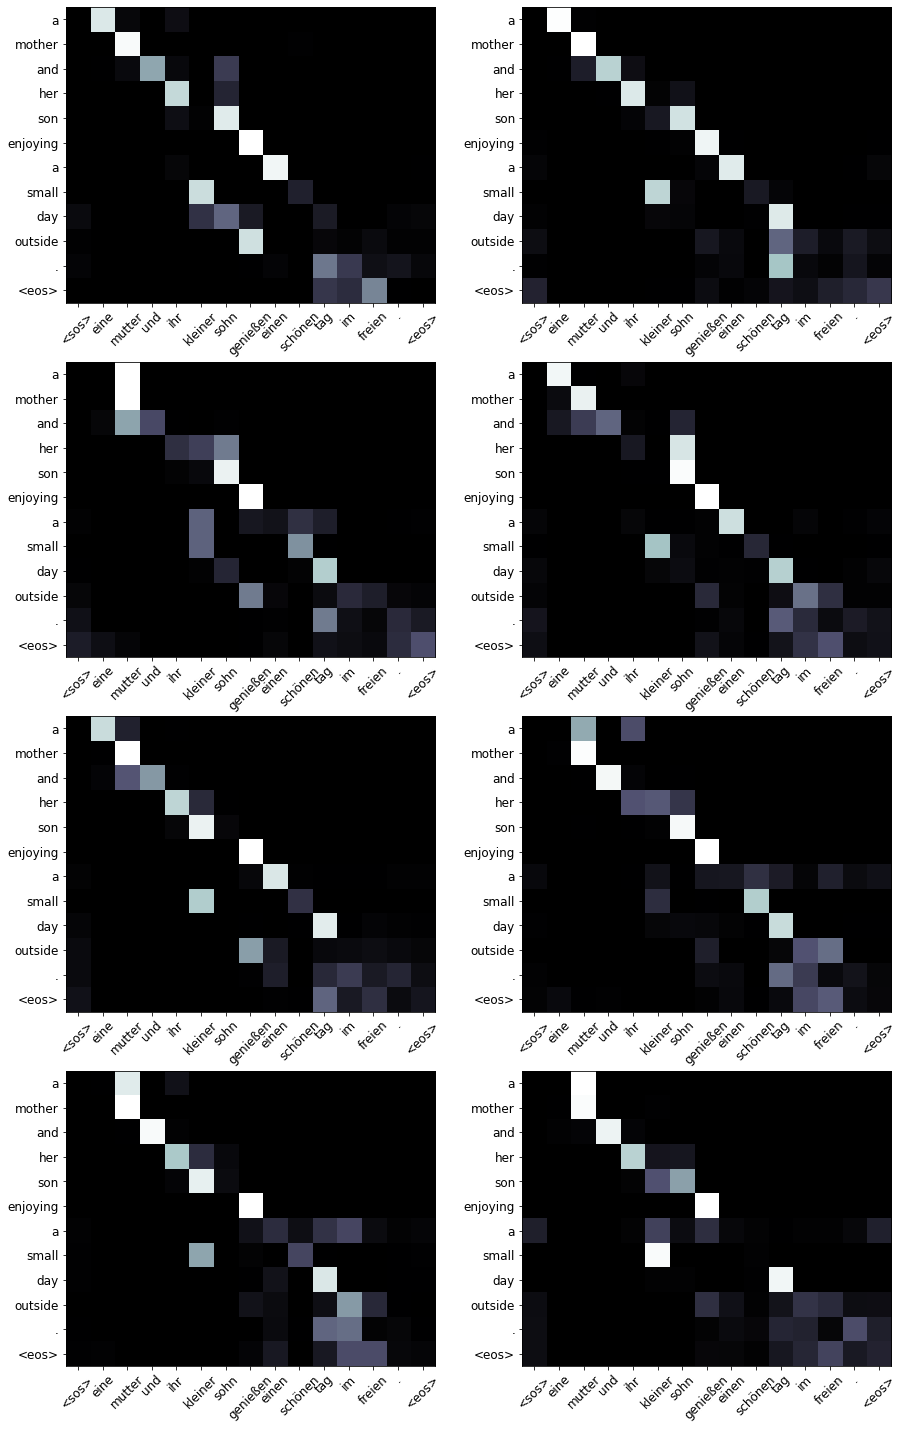

In [ ]:
display_attention(src, translation, attention)

<br>

## 1.13 BLEU Score 계산

- 학습된 트랜스포머(Transformer) 모델의 BLEU 스코어 계산

In [ ]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        pred_trg = pred_trg[:-1] # 마지막 <eos> 토큰 제거

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index+1:04d}/{len(data):04d}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    print()
    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')
    print()

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}') 
    print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}') 
    print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}') 
    print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}') 
    print()

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}') 
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}') 
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}') 
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}')     

In [ ]:
show_bleu(test_dataset, SRC, TRG, model, device)

[0100/1000]
예측: ['a', 'group', 'of', 'asian', 'children', 'sit', 'in', 'blue', 'chairs', 'down', 'chairs', '.']
정답: ['a', 'group', 'of', 'mostly', 'asian', 'children', 'sitting', 'at', 'cubicles', 'in', 'blue', 'chairs', '.']
[0200/1000]
예측: ['all', 'in', 'the', 'group', 'of', 'the', 'birds', 'are', 'standing', 'under', 'umbrellas', '.']
정답: ['the', 'group', 'of', 'people', 'are', 'all', 'covered', 'by', 'umbrellas', '.']
[0300/1000]
예측: ['a', '<unk>', 'player', 'in', 'a', 'yellow', 'jersey', 'is', 'handing', 'out', 'the', 'goal', '.']
정답: ['a', 'goalie', 'in', 'a', 'yellow', 'field', 'is', 'protecting', 'the', 'goal', '.']
[0400/1000]
예측: ['two', 'young', 'children', 'on', 'the', 'sand', '.']
정답: ['two', 'young', 'children', 'are', 'on', 'sand', '.']
[0500/1000]
예측: ['two', '<unk>', 'dogs', 'running', 'across', 'the', 'snow', '.']
정답: ['two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']
[0600/1000]
예측: ['a', 'group', 'of', 'men', 'are', 'sitting', 'and', 'talking', 